## Goal. train 데이터와 test data 비교해보기

---

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error # squared=True 기본
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
from tqdm import tqdm
import shutil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
pd.set_option('display.max_rows', None)

### 기본 train data & test data 가져오기

In [5]:
train = pd.read_csv('../data/train/train.csv')
print(train.shape)
train.head(1)

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0


In [30]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


In [8]:
dfs = []
for i in tqdm(range(81)): # 81
    path = '../data/test/{}.csv'.format(i)
    df = pd.read_csv(path)
    dfs.append(df)
test_df = pd.concat(dfs, axis=0).reset_index(drop=True)
print(test_df.shape)
test_df.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 64.35it/s]


(27216, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.7,34.42,0.0,0.0


### 기존 column별로 data 분포 비교
- 기본 데이터를 비교해본 결과 RH와 T의 경우 train과 test의 분포가 꽤나 다름
- 특히 RH의 경우 range자체가 다름 → train 기준으로 scaling을 적용할 경우 안 좋은 효과가 나타날 수 있음

#### 1. DHI

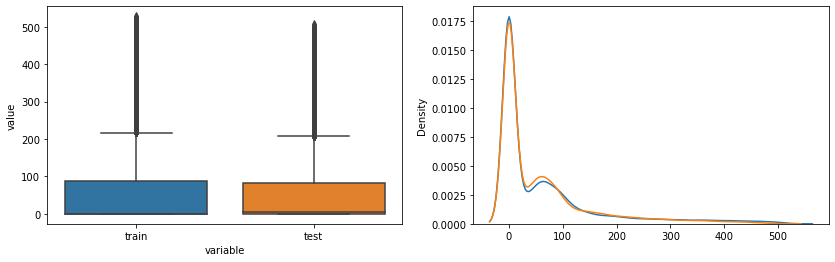

In [73]:
dhi = pd.concat([train.DHI, test_df.DHI],axis=1)
dhi.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dhi), ax=ax[0])
for col in dhi.columns:
    sns.distplot(dhi[[col]], hist=False, rug=False, ax=ax[1])

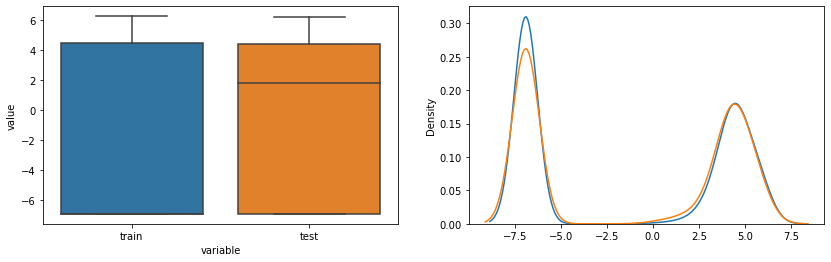

In [238]:
dhi = pd.concat([np.log(train.DHI+0.001), np.log(test_df.DHI+0.001)],axis=1)
dhi.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dhi), ax=ax[0])
for col in dhi.columns:
    sns.distplot(dhi[[col]], hist=False, rug=False, ax=ax[1])

#### 2. DNI

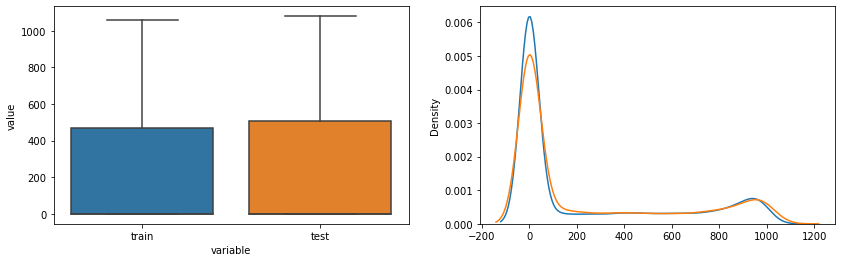

In [74]:
dni = pd.concat([train.DNI, test_df.DNI],axis=1)
dni.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dni), ax=ax[0])
for col in dni.columns:
    sns.distplot(dni[[col]], hist=False, rug=False, ax=ax[1])

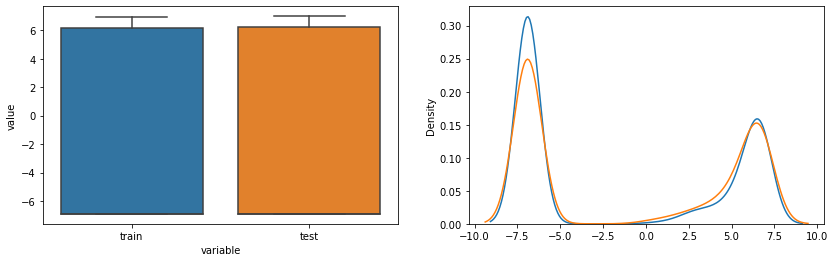

In [239]:
dni = pd.concat([np.log(train.DNI+0.001), np.log(test_df.DNI+0.001)],axis=1)
dni.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dni), ax=ax[0])
for col in dni.columns:
    sns.distplot(dni[[col]], hist=False, rug=False, ax=ax[1])

#### 3. WS

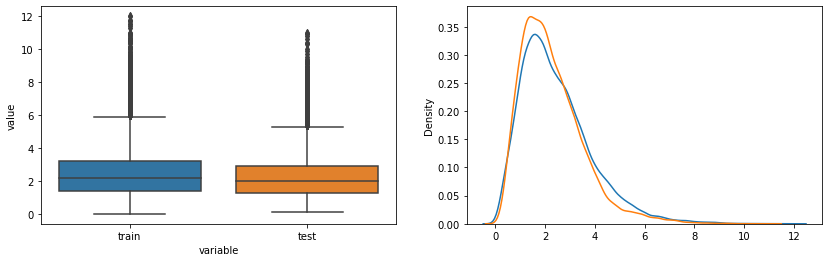

In [75]:
ws = pd.concat([train.WS, test_df.WS],axis=1)
ws.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(ws), ax=ax[0])
for col in ws.columns:
    sns.distplot(ws[[col]], hist=False, rug=False, ax=ax[1])

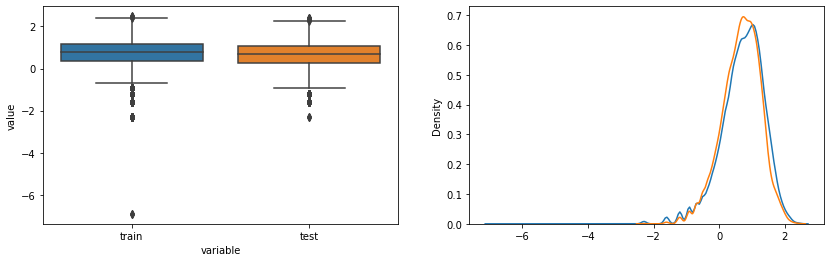

In [240]:
ws = pd.concat([np.log(train.WS+0.001), np.log(test_df.WS+0.001)],axis=1)
ws.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(ws), ax=ax[0])
for col in ws.columns:
    sns.distplot(ws[[col]], hist=False, rug=False, ax=ax[1])

#### 4. RH

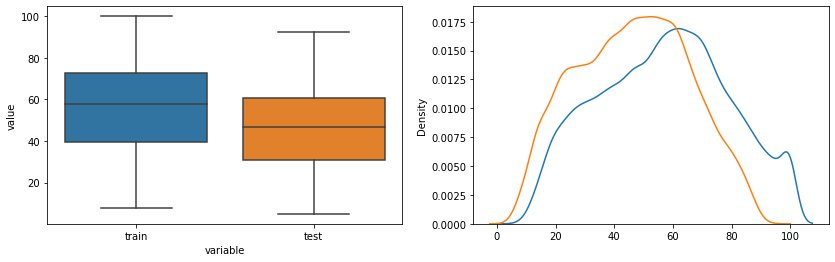

In [76]:
rh = pd.concat([train.RH, test_df.RH],axis=1)
rh.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(rh), ax=ax[0])
for col in rh.columns:
    sns.distplot(rh[[col]], hist=False, rug=False, ax=ax[1])

#### 5. T

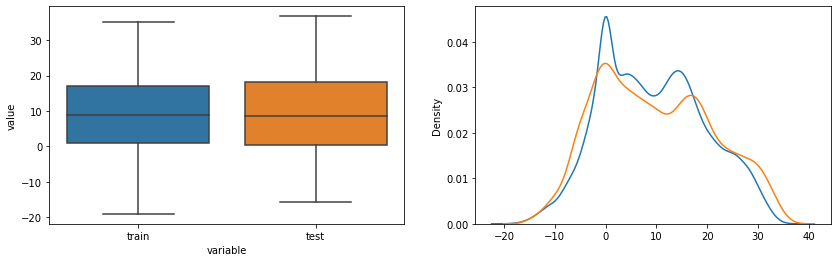

In [77]:
t = pd.concat([train['T'], test_df['T']],axis=1)
t.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(t), ax=ax[0])
for col in t.columns:
    sns.distplot(t[[col]], hist=False, rug=False, ax=ax[1])

#### 6. TARGET

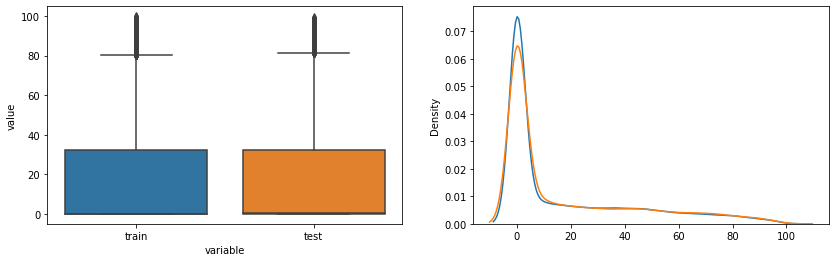

In [78]:
target = pd.concat([train.TARGET, test_df.TARGET],axis=1)
target.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(target), ax=ax[0])
for col in target.columns:
    sns.distplot(target[[col]], hist=False, rug=False, ax=ax[1])

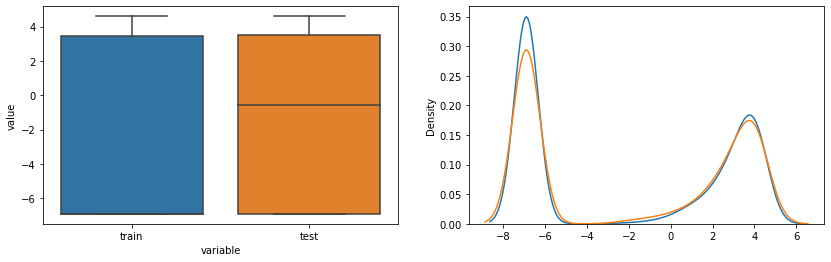

In [262]:
target = pd.concat([np.log(train.TARGET+0.001), np.log(test_df.TARGET+0.001)],axis=1)
target.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(target), ax=ax[0])
for col in target.columns:
    sns.distplot(target[[col]], hist=False, rug=False, ax=ax[1])

In [254]:
a = np.array([10,0])
b = np.log(a+0.001)
np.round(np.exp(b)-0.001,6)

array([10.,  0.])

---

### 새로운 컬럼을 추가한 train data & test data 가져오기 및 생성

In [56]:
# test['GHI'] = test['DHI'] + test['DNI']
def GHI(data):
    return data['DHI'] + data['DNI']

In [57]:
def dewpoint(data):
    rh = data['RH']
    t = data['T']
    gamma = math.log(rh/100) + (17.62*t)/(243.12*t+0.001)
    dew = (243.12*gamma)/(17.62-gamma)
    return dew

In [58]:
def dew(data):
    return [dewpoint(data.iloc[i]) for i in range(len(data.index))]

In [59]:
# Hour & Minute 모두 비교
def time_minute(data):
    hour = data['Hour']
    if data['Minute'] == 0:
        minute = 0
    else: # ==30
        minute = 0.5
    return hour + minute

In [60]:
def suns(data,col='sunny'):
    ghi = data.iloc[np.where(data['DHI'] + data['DNI'] > 0)[0],:].reset_index(drop=True)
    ghi['time_float'] = [time_minute(ghi.iloc[i]) for i in range(len(ghi.index))]
    ghi_min_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].min()).reset_index()
    ghi_max_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].max()).reset_index()
    
    if col == 'sunny':
        ghi_minus_hour = ghi_max_hour.copy()
        ghi_minus_hour['sunny'] = ghi_max_hour['time_float'] - ghi_min_hour['time_float']
        result = pd.merge(data, ghi_minus_hour[['Day','sunny']], on='Day')
        return result['sunny']
    elif col == 'sunrise':
        ghi_min_hour.columns = ['Day', 'sunrise']
        result = pd.merge(data, ghi_min_hour, on='Day')
        return result['sunrise']
    elif col == 'sunset':
        ghi_max_hour.columns = ['Day', 'sunset']
        result = pd.merge(data, ghi_max_hour, on='Day')
        return result['sunset']
    else:
        raise Exception('wrong input')

In [61]:
def cloudy(data):
    return data['DHI']/(data['DNI']+0.001)

In [62]:
def temp_diff(data):
    max_temp = pd.DataFrame(data.groupby(['Day'])['T'].max()).reset_index()
    min_temp = pd.DataFrame(data.groupby(['Day'])['T'].min()).reset_index()
    diff = min_temp.copy() ; diff=diff.drop(['T'],axis=1,)
    diff['temp_diff'] = max_temp['T'] - min_temp['T']
    result = pd.merge(data,diff,on='Day')
    return result['temp_diff']

In [63]:
def delta(data):
    del_model = joblib.load('model/test_delta.pkl')
    predicted_del = del_model.predict(data.drop(['Day'],axis=1))
    return predicted_del  

In [64]:
def HRA(data):
    hour = data['Hour']
    return 15*(hour-12)

def elevation(data): # -90 ~ 90
    de = math.radians(data['delta'])
    lat = math.radians(36) # 위도는 남한 반도의 중간인 36으로 설정
    hra = math.radians(HRA(data))
    return math.degrees(math.asin(math.sin(de)*math.sin(lat) + math.cos(de)*math.cos(lat)*math.cos(hra)))

def zen_angle(data):
    angle = 90 - elevation(data)
    return angle 

def zenith(data):
    return [zen_angle(data.iloc[i]) for i in range(len(data.index))]

In [65]:
def azimuth(data):
    hra = math.radians(HRA(data))
    de = math.radians(data['delta'])
    lat = math.radians(36)
    ele = math.radians(elevation(data))
    
    top = round(math.sin(de)*math.cos(lat) - math.cos(de)*math.sin(lat)*math.cos(hra),5)
    bottom = round(math.cos(ele),5)
    azi = math.degrees(math.acos(top/bottom))
    if hra > 0:
        return 360 - azi
    else:
        return azi

In [66]:
def azi(data):
    return [azimuth(data.iloc[i]) for i in range(len(data.index))]

In [67]:
def test_preprocess1(df):
    data = df.copy()
    data['GHI'] = GHI(data)
    data['dew'] = dew(data)
    data['sunny'] = suns(data,col='sunny')
    data['sunrise'] = suns(data,col='sunrise')
    data['sunset'] = suns(data,col='sunset')
    data['cloudy'] = cloudy(data)
    data['temp_diff'] = temp_diff(data)
    data['delta'] = delta(data)
    return data

def test_preprocess2(df):
    data = df.copy()
    data['zenith'] = zenith(data)
    data['azi'] = azi(data)
    return data

In [68]:
train = pd.read_csv('train/train_new.csv')
no_date = train.drop(['date'],axis=1)
print(no_date.shape)
no_date.head(1)

(52560, 19)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,cloudy,temp_diff,delta,zenith,azi
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-4.035806,8.5,8.0,16.5,0.0,9,-23.169132,167.169132,0.0


In [70]:
dfs = []
for i in tqdm(range(81)): # 81
    path = 'test/{}.csv'.format(i)
    df = pd.read_csv(path)
    df1 = test_preprocess1(df)
    df2 = test_preprocess2(df1)
    dfs.append(df2)
test_df = pd.concat(dfs, axis=0).reset_index(drop=True)
print(test_df.shape)
test_df.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:29<00:00,  2.76it/s]

(27216, 19)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,cloudy,temp_diff,delta,zenith,azi
0,0,0,0,0,0,2.7,34.42,0.0,0.0,0,-13.876055,9.0,7.5,16.5,0.0,11.8,-19.766979,163.766979,0.0


### 새로운 column별로 data 분포 비교
- test 데이터의 경우 2년치 데이터라고는 하지만, **봄~가을까지의 데이터가 주**를 이루는 것 같음
    - 3년치 데이터에 비해 2년치 데이터때 지구의 온도가 올라간 것이 아닌 이상, test 데이터에는 한창 겨울의 데이터는 존재하지 않는 듯
    - 이로 인해, 날씨와 관련된 변수들의 경우 train / test의 분포가 매우 다름 (range도) → **scaling은 사용하지 않는 것이 좋을 듯**
- 제공된 test 데이터가 실제 test 데이터의 일부분이라면 너무 해당 데이터에만 fit하게 만들면 안됨
- scaling은 쓰지 않되, model도 complex하게 만들지 말아야 할 듯
- 일단은, **feature를 조작**하는 것을 먼저 시도해봐야 할 듯
    

#### 7. GHI

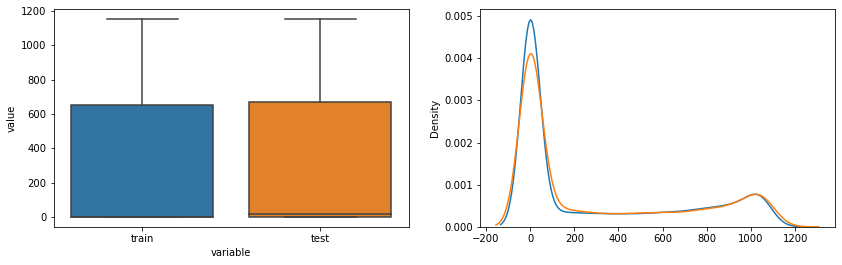

In [72]:
ghi = pd.concat([no_date.GHI, test_df.GHI],axis=1)
ghi.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(ghi), ax=ax[0])
for col in ghi.columns:
    sns.distplot(ghi[[col]], hist=False, rug=False, ax=ax[1])

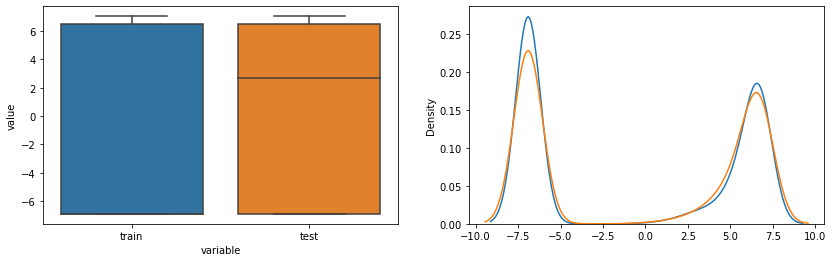

In [255]:
ghi = pd.concat([np.log(no_date.GHI+0.001), np.log(test_df.GHI+0.001)],axis=1)
ghi.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(ghi), ax=ax[0])
for col in ghi.columns:
    sns.distplot(ghi[[col]], hist=False, rug=False, ax=ax[1])

#### 8. dew

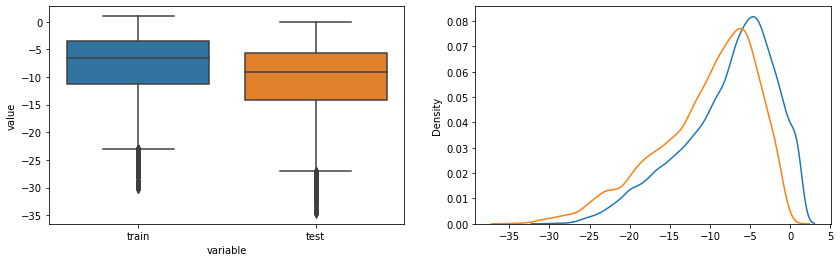

In [79]:
dew = pd.concat([no_date.dew, test_df.dew],axis=1)
dew.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dew), ax=ax[0])
for col in dew.columns:
    sns.distplot(dew[[col]], hist=False, rug=False, ax=ax[1])

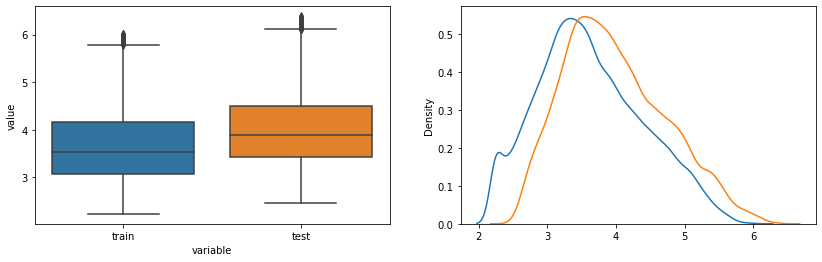

In [265]:
dew = pd.concat([np.sqrt(5 - no_date.dew + 1), np.sqrt(5 - test_df.dew + 1)],axis=1)
dew.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(dew), ax=ax[0])
for col in dew.columns:
    sns.distplot(dew[[col]], hist=False, rug=False, ax=ax[1])

#### 9. sunny

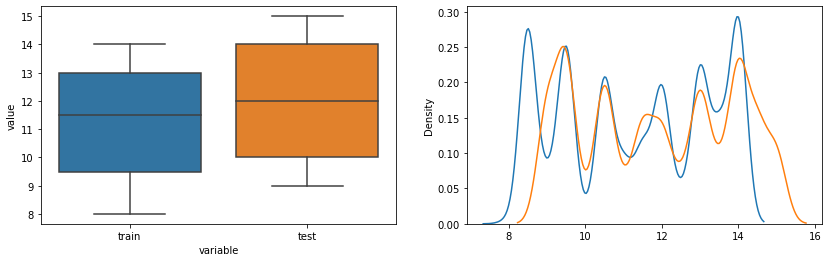

In [80]:
sunny = pd.concat([no_date.sunny, test_df.sunny],axis=1)
sunny.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(sunny), ax=ax[0])
for col in sunny.columns:
    sns.distplot(sunny[[col]], hist=False, rug=False, ax=ax[1])

#### 10. sunrise

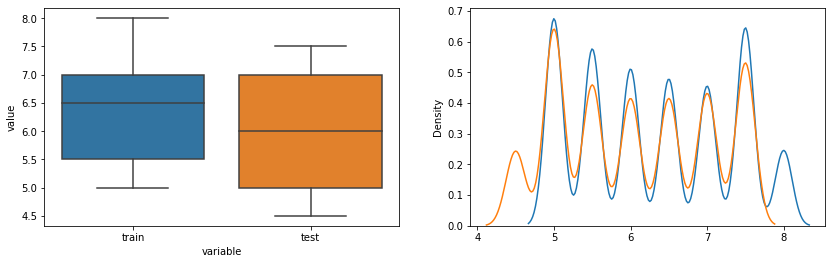

In [81]:
sunrise = pd.concat([no_date.sunrise, test_df.sunrise],axis=1)
sunrise.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(sunrise), ax=ax[0])
for col in sunrise.columns:
    sns.distplot(sunrise[[col]], hist=False, rug=False, ax=ax[1])

#### 11. sunset

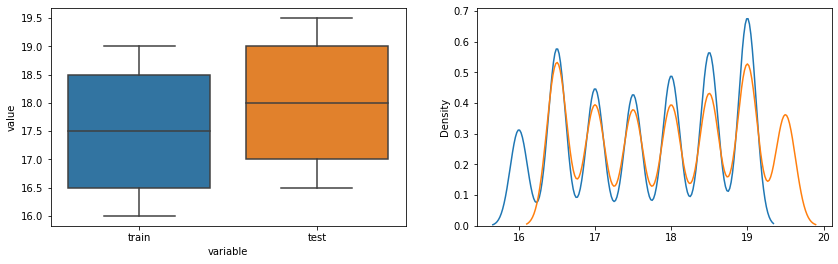

In [82]:
sunset = pd.concat([no_date.sunset, test_df.sunset],axis=1)
sunset.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(sunset), ax=ax[0])
for col in sunset.columns:
    sns.distplot(sunset[[col]], hist=False, rug=False, ax=ax[1])

#### 12. cloudy

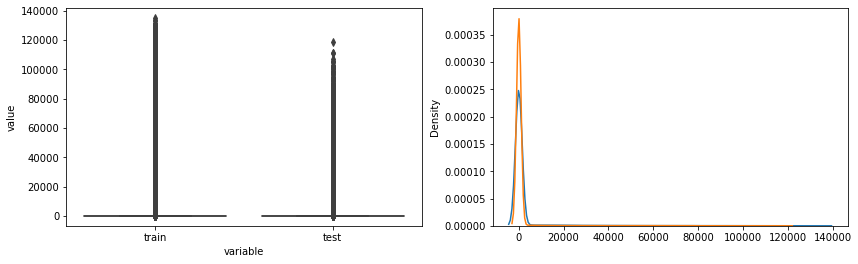

In [83]:
cloudy = pd.concat([no_date.cloudy, test_df.cloudy],axis=1)
cloudy.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(cloudy), ax=ax[0])
for col in cloudy.columns:
    sns.distplot(cloudy[[col]], hist=False, rug=False, ax=ax[1])

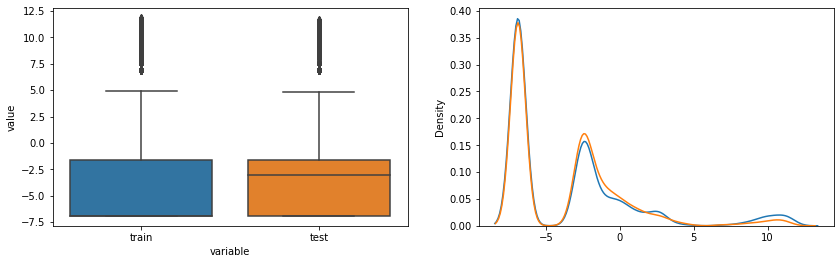

In [263]:
cloudy = pd.concat([np.log(no_date.cloudy+0.001), np.log(test_df.cloudy+0.001)],axis=1)
cloudy.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(cloudy), ax=ax[0])
for col in cloudy.columns:
    sns.distplot(cloudy[[col]], hist=False, rug=False, ax=ax[1])

#### 13. temp_diff

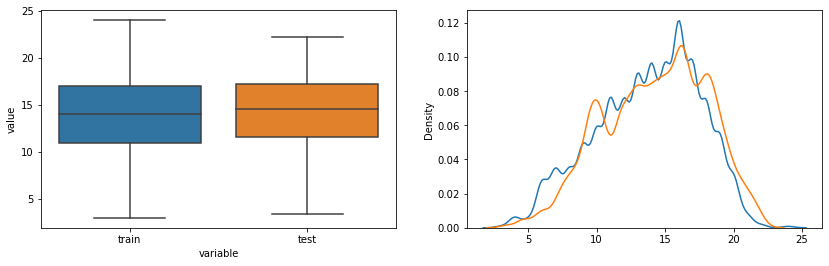

In [84]:
temp_diff = pd.concat([no_date.temp_diff, test_df.temp_diff],axis=1)
temp_diff.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(temp_diff), ax=ax[0])
for col in temp_diff.columns:
    sns.distplot(temp_diff[[col]], hist=False, rug=False, ax=ax[1])

#### 14. delta

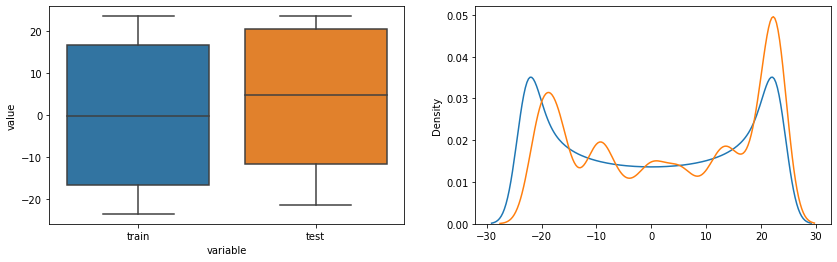

In [85]:
delta = pd.concat([no_date.delta, test_df.delta],axis=1)
delta.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(delta), ax=ax[0])
for col in delta.columns:
    sns.distplot(delta[[col]], hist=False, rug=False, ax=ax[1])

#### 15. zenith

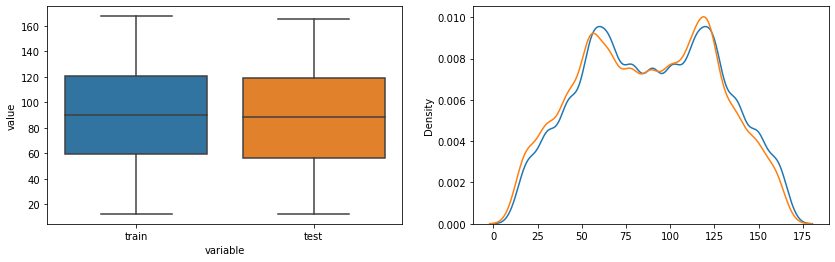

In [86]:
zenith = pd.concat([no_date.zenith, test_df.zenith],axis=1)
zenith.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(zenith), ax=ax[0])
for col in zenith.columns:
    sns.distplot(zenith[[col]], hist=False, rug=False, ax=ax[1])

#### 16. azi

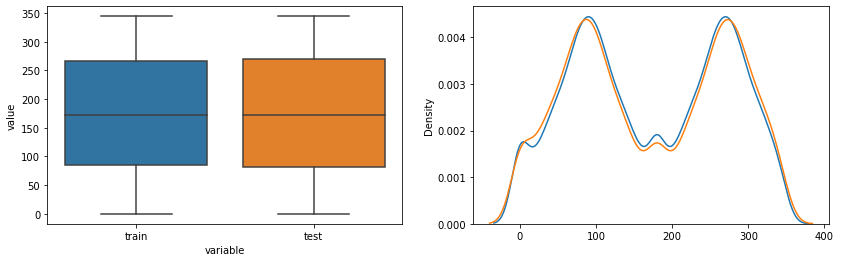

In [87]:
azi = pd.concat([no_date.azi, test_df.azi],axis=1)
azi.columns = ['train','test']
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(x='variable', y='value', data=pd.melt(azi), ax=ax[0])
for col in azi.columns:
    sns.distplot(azi[[col]], hist=False, rug=False, ax=ax[1])

---

### 가능한 데이터 경우의 수
- (1) 데이터의 분포가 유독 다른 RH, sunny, sunrise, sunset, dew **feature 자체를 삭제** + 새로운 컬럼 추가
- (2) RH, sunny, sunrise, sunset, dew **feature에 맞게 데이터 row를 삭제** + 새로운 컬럼 추가
    - 이럴 경우, 한겨울 데이터들이 많이 날라감

---

### Train과 Test의 두 변수간 분포 차이 확인

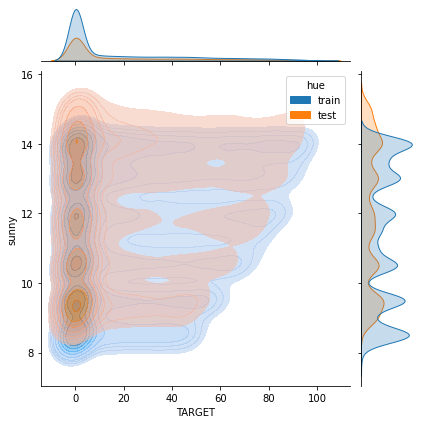

In [102]:
df = pd.concat([no_date[['TARGET','sunny']], test_df[['TARGET','sunny']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(no_date.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='TARGET',y='sunny',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

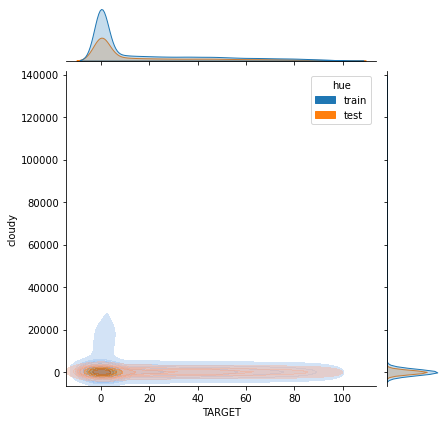

In [103]:
df = pd.concat([no_date[['TARGET','cloudy']], test_df[['TARGET','cloudy']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(no_date.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='TARGET',y='cloudy',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

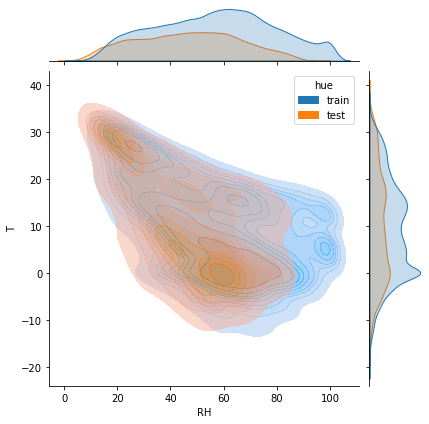

In [101]:
df = pd.concat([no_date[['RH','T']], test_df[['RH','T']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(no_date.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='RH',y='T',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

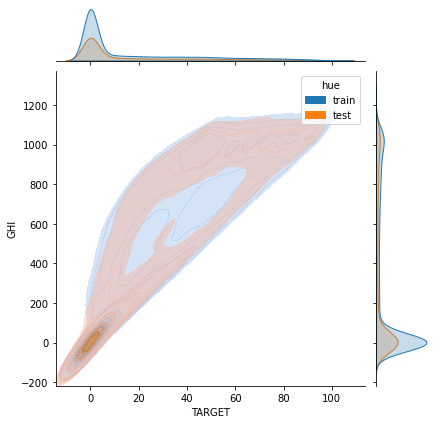

In [221]:
df = pd.concat([no_date[['GHI','TARGET']], test_df[['GHI','TARGET']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(no_date.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='TARGET',y='GHI',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

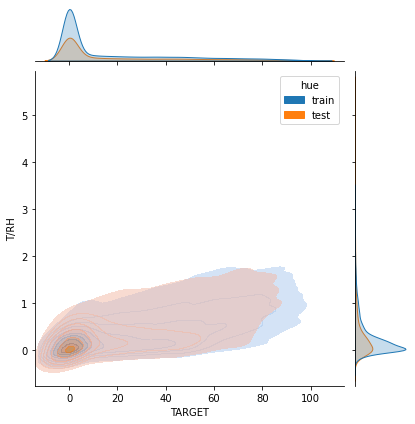

In [235]:
df1 = no_date.copy() ; df2 = test_df.copy()
df1['T/RH'] = df1[['T']].values / df1[['RH']].values
df2['T/RH'] = df2[['T']].values / df2[['RH']].values
df = pd.concat([df1[['T/RH','TARGET']], df2[['T/RH','TARGET']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(df1.shape[0])] + ['test' for i in range(df2.shape[0])]
sns.jointplot(x='TARGET',y='T/RH',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

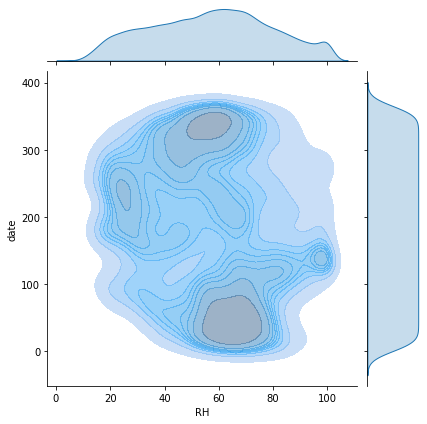

In [104]:
sns.jointplot(x='RH',y='date',data=train,kind='kde',fill=True, joint_kws={'alpha': 0.5})

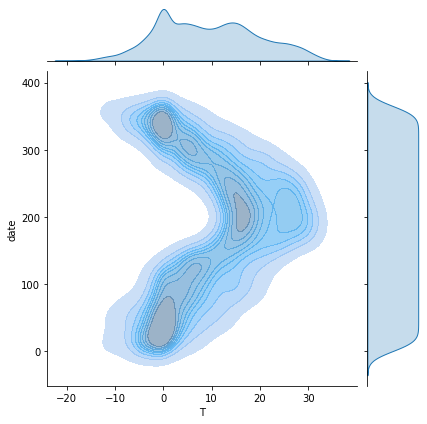

In [105]:
sns.jointplot(x='T',y='date',data=train,kind='kde',fill=True, joint_kws={'alpha': 0.5})

---

### Train 데이터 자르기

#### RH가 95이상인 경우 다 잘라내야할 듯 → 봄 데이터

#### 7일 데이터 기준

In [277]:
over = train.iloc[np.where(train.RH >= 93)[0]].Day.unique()

In [278]:
# target2의 RH값이 93이상인 경우는 그럴 수도 있으므로 포함
day_ls = []
for d in range(len(over)):
    if (d < (len(over)-1)):
        if ((over[d]+9) < over[d+1]):
            day_ls.append([over[d]+1, over[d+1]-1])
    if (d == (len(over)-1)) & ((over[d]+9) <= 1094):
        day_ls.append([over[d]+1, 1094]) # Day: 0~1094

In [279]:
# TARGET 데이터만
train_df = pd.DataFrame()
for i in tqdm(range(len(day_ls))):
    days = day_ls[i]
    start_day = days[0] ; last_day = days[1]
    df = train.loc[(train.Day>=start_day)&(train.Day<=last_day)].reset_index(drop=True)

    temp_df = pd.DataFrame([df.iloc[i:(i+289),:][['TARGET']].T.values.tolist()[0] for i in range((df.shape[0]-289+1))])
    target1 = df.iloc[48*7:,:][['TARGET']].reset_index(drop=True) 
    target2 = df.iloc[48*8:,:][['TARGET']].reset_index(drop=True)
    temp_df = pd.concat([temp_df.iloc[:target2.shape[0]], target1.iloc[:target2.shape[0]], target2],axis=1).reset_index(drop=True)

    train_df = pd.concat([train_df,temp_df],axis=0).reset_index(drop=True)
    
train_df.columns = ['{}'.format(j) for j in range(289)] + ['target1','target2']
print(train_df.shape)
train_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:11<00:00,  2.64it/s]

(14880, 291)


,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,target1,target2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
train_df.to_csv('train_refined/new_row_removed.csv',index=False) # no log

In [280]:
train_log_df = np.log(train_df+0.001) 
train_log_df.to_csv('train_refined/new_row_removed_log.csv',index=False) # log

In [197]:
# 전체 컬럼
train_df = pd.DataFrame()
for i in tqdm(range(len(day_ls))):
    days = day_ls[i]
    start_day = days[0] ; last_day = days[1]
    df = train.loc[(train.Day>=start_day)&(train.Day<=last_day)].reset_index(drop=True)
    train_df = pd.concat([train_df,df],axis=0).reset_index(drop=True)

print(train_df.shape)
train_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 209.69it/s]

(26784, 20)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff,delta,zenith,azi
0,31,0,0,0,0,2.5,89.18,-5,0.0,0,-0.578669,9.5,7.5,17.0,31,0.0,7,-18.107072,162.107072,0.0
1,31,0,30,0,0,2.8,89.21,-5,0.0,0,-0.574050,9.5,7.5,17.0,31,0.0,7,-18.107072,162.107072,0.0


---

In [201]:
over = train.iloc[np.where(train.RH >= 93)[0]].Day.unique()

In [202]:
# target2의 RH값이 92.5이상일 때도 안되게 - 분포 확인을 위해
day_ls = []
for d in range(len(over)):
    if (d < (len(over)-1)):
        if ((over[d]+9) < over[d+1]):
            day_ls.append([over[d]+1, over[d+1]-1])
    if (d == (len(over)-1)) & ((over[d]+9) <= 1094):
        day_ls.append([over[d]+1, 1094]) # Day: 0~1094
        
# 전체 컬럼
train_df = pd.DataFrame()
for i in tqdm(range(len(day_ls))):
    days = day_ls[i]
    start_day = days[0] ; last_day = days[1]
    df = train.loc[(train.Day>=start_day)&(train.Day<=last_day)].reset_index(drop=True)
    train_df = pd.concat([train_df,df],axis=0).reset_index(drop=True)

print(train_df.shape)
train_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 212.90it/s]

(26784, 20)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff,delta,zenith,azi
0,31,0,0,0,0,2.5,89.18,-5,0.0,0,-0.578669,9.5,7.5,17.0,31,0.0,7,-18.107072,162.107072,0.0
1,31,0,30,0,0,2.8,89.21,-5,0.0,0,-0.574050,9.5,7.5,17.0,31,0.0,7,-18.107072,162.107072,0.0


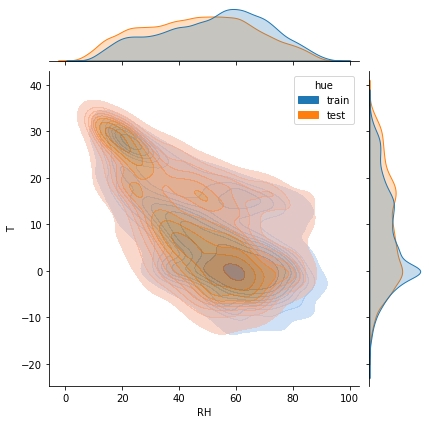

In [203]:
df = pd.concat([train_df[['RH','T']], test_df[['RH','T']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(train_df.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='RH',y='T',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

In [204]:
train_df.RH.max()

92.9

---

#### 3일 데이터 기준

In [214]:
over = train.iloc[np.where(train.RH >= 92.7)[0]].Day.unique()

In [215]:
# target2의 RH값이 93이상인 경우는 그럴 수도 있으므로 포함
day_ls = []
for d in range(len(over)):
    if (d < (len(over)-1)):
        if ((over[d]+5) < over[d+1]):
            day_ls.append([over[d]+1, over[d+1]-1])
    if (d == (len(over)-1)) & ((over[d]+5) <= 1094):
        day_ls.append([over[d]+1, 1094]) # Day: 0~1094

In [216]:
# 전체 컬럼
train_df = pd.DataFrame()
for i in tqdm(range(len(day_ls))):
    days = day_ls[i]
    start_day = days[0] ; last_day = days[1]
    df = train.loc[(train.Day>=start_day)&(train.Day<=last_day)].reset_index(drop=True)
    train_df = pd.concat([train_df,df],axis=0).reset_index(drop=True)

print(train_df.shape)
train_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 184.28it/s]

(32112, 20)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff,delta,zenith,azi
0,14,0,0,0,0,2.1,52.65,-5,0.0,0,-7.605817,8.5,8.0,16.5,14,0.0,13,-21.635897,165.635897,0.0
1,14,0,30,0,0,2.1,52.67,-5,0.0,0,-7.600899,8.5,8.0,16.5,14,0.0,13,-21.635897,165.635897,0.0


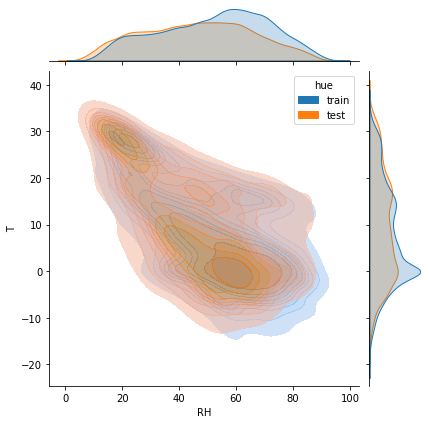

In [217]:
df = pd.concat([train_df[['RH','T']], test_df[['RH','T']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(train_df.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='RH',y='T',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

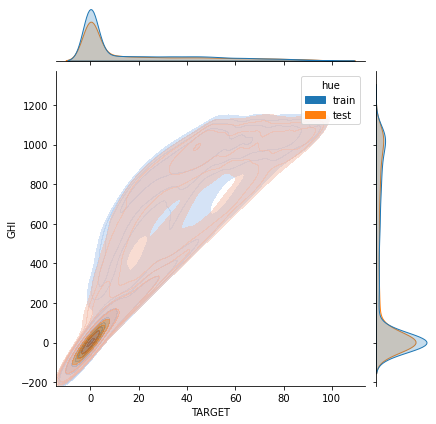

In [218]:
df = pd.concat([train_df[['GHI','TARGET']], test_df[['GHI','TARGET']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(train_df.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='TARGET',y='GHI',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

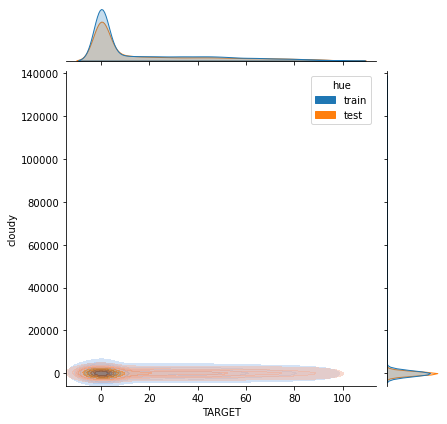

In [222]:
df = pd.concat([train_df[['TARGET','cloudy']], test_df[['TARGET','cloudy']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(train_df.shape[0])] + ['test' for i in range(test_df.shape[0])]
sns.jointplot(x='TARGET',y='cloudy',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})

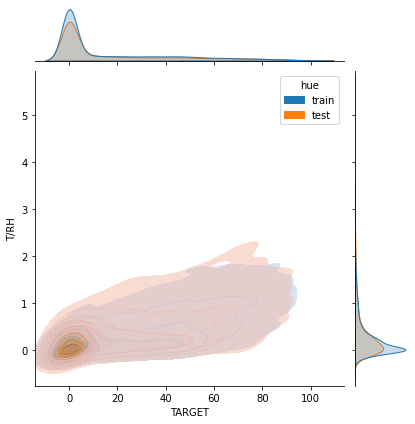

In [236]:
df1 = train_df.copy() ; df2 = test_df.copy()
df1['T/RH'] = df1[['T']].values / df1[['RH']].values
df2['T/RH'] = df2[['T']].values / df2[['RH']].values
df = pd.concat([df1[['T/RH','TARGET']], df2[['T/RH','TARGET']]],axis=0).reset_index(drop=True)
df['hue'] = ['train' for i in range(df1.shape[0])] + ['test' for i in range(df2.shape[0])]
sns.jointplot(x='TARGET',y='T/RH',hue='hue',data=df,kind='kde',fill=True, joint_kws={'alpha': 0.5})